In [2]:
import os
import sys

sys.path.append(f"{os.getcwd()}/../")

In [3]:
from collections import defaultdict
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier

from gensim.models import Word2Vec, Doc2Vec

import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Bidirectional, 
    LSTM, GRU, Embedding, SpatialDropout1D, GlobalMaxPooling1D, 
    GlobalAveragePooling1D, Conv1D, TimeDistributed, MaxPool1D, Flatten
)
from tensorflow.compat.v1.keras.layers import CuDNNLSTM 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from processing.utils import CleanUp, RSLP_STEMMER, SNOWBALL_STEMMER, NLP_LEMMATIZER

%matplotlib inline

clean_up = CleanUp()

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices("GPU")))

Num GPUs Available:  1


In [4]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1



In [5]:
classes = 2
max_words = 10000
maxlen = 64
batch_size = 32
epochs = 10

In [6]:
df = pd.read_csv(f"{os.getcwd()}/../../data/dataset.csv", sep="|")
df["x"] = df["comentario"].apply(lambda comment: clean_up.fit(str(comment)))
df["y"] = df["classificacao"].apply(lambda clasf: 0 if clasf == "negativo" else 1)
textos = df[["x", "y"]].to_numpy()

In [7]:
print(random.choice(textos))
print(len(textos))
# print(df[df['x'] == ''].index)
# print(df.loc[250])

['com fobia por causa mascara nao posso nem respirar fundo vao achar com falta por causa corona'
 0]
2044


In [682]:
# word_counts = defaultdict(int)
# for phrases in textos[:, 0]:
#     for word in phrases.split():
#         word_counts[word] += 1
# v_count = len(word_counts.keys())
# words_list = list(word_counts.keys())
# word_index = dict((word, i) for i, word in enumerate(words_list))

# X = []
# for phrases in textos[:, 0]:
#     xp = []
#     for word in phrases.split():
#         xp.append(word_index[word])
#     X.append(xp)
# y = textos[:, 1].astype(np.int).ravel()
# y = to_categorical(y, classes)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# tokenizer = Tokenizer(num_words=max_words)
# X_train = tokenizer.sequences_to_matrix(X_train, mode='binary')
# X_test = tokenizer.sequences_to_matrix(X_test, mode='binary')

In [683]:
X = textos[:, 0]
y = textos[:, 1].astype(np.int).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

tokenizer = Tokenizer(num_words=max_words, lower=True, char_level=False)
tokenizer.fit_on_texts(X)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

clf = LogisticRegression(
    random_state=0
).fit(X_train, y_train)
pred = clf.predict(X_test)

round(np.mean(y_test == pred) * 100)

65.0

In [684]:
X = textos[:, 0]
y = textos[:, 1].astype(np.int).ravel()
y = to_categorical(y, classes)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

tokenizer = Tokenizer(num_words=max_words, lower=True, char_level=False)
tokenizer.fit_on_texts(X)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [685]:
X_train[0], X_test[0]

(array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   1,   6,  17,  45,   1,  11, 398],
       dtype=int32),
 array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    7, 5260, 5261,   44,   61,  636,  376,    5], dtype=int32))

In [686]:
model = Sequential()
# model.add(Dense(1024, input_shape=(max_words,)))
model.add(Embedding(input_dim=vocab_size, 
                            output_dim=32, 
                            input_length=maxlen))
model.add(Conv1D(32, 2, activation='relu'))
# model.add(MaxPool1D())
# model.add(Conv1D(32, 3, activation='relu'))
# model.add(Conv1D(64, 3, activation='relu'))
# model.add(SpatialDropout1D(0.1))
# model.add(Bidirectional(GRU(4)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(classes))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.metrics_names)

[]


In [687]:
# # For Conv & LSTM
# print(X_train.shape)
# print(X_test.shape)
# # X_train = X_train.reshape(1430, 15000, -1)
# # X_test = X_test.reshape(614, 15000, -1)
# X_train = X_train.astype(np.float32)
# X_test = X_test.astype(np.float32)

(1635, 64)
(409, 64)


In [688]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0) # , validation_split=0.2)
score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', round(score[1] * 100))

13/13 [==============================] - 0s 2ms/step - loss: 1.3226 - accuracy: 0.7139
Test loss: 1.3225661516189575
Test accuracy: 71


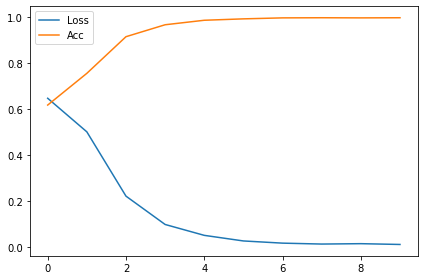

In [689]:
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["accuracy"], label="Acc")
plt.xticks(range(0, epochs, 2))
plt.legend()
plt.tight_layout()
plt.show()

### Do2Vec

In [8]:
d2v = Doc2Vec.load(f"{os.getcwd()}/../ai/models/d2v.model")

n_textos = []
for texto in textos:
    doc_vec = d2v.infer_vector(texto[0].split())
    n_textos.append(doc_vec)
n_textos = np.asarray(n_textos)

In [68]:
X = n_textos
y = textos[:, 1].astype(np.int).ravel()
y = to_categorical(y, classes)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [69]:
# # For Conv & LSTM
print(X_train.shape)
print(X_test.shape)
X_train = X_train.reshape(1635, 300, -1)
X_test = X_test.reshape(409, 300, -1)
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

(1635, 300)
(409, 300)


In [92]:
model = Sequential()
# model.add(Dense(1024, input_shape=(300,)))
model.add(Conv1D(32, 2, activation='relu'))
model.add(MaxPool1D())
# model.add(Conv1D(32, 3, activation='relu'))
# model.add(Conv1D(64, 3, activation='relu'))
model.add(SpatialDropout1D(0.1))
# model.add(Bidirectional(GRU(4)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(classes))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.metrics_names)

[]


In [93]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_split=0.2)
score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', round(score[1] * 100))

13/13 [==============================] - 0s 2ms/step - loss: 0.9229 - accuracy: 0.6357
Test loss: 0.9228871464729309
Test accuracy: 64
